In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.datasets import make_classification
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# ==========================================
# 0. Data prepare
# ==========================================
def load_data(file_path='creditcard.csv'):
    """
    read creditcard.csv
    """
    try:
        print(f"Reading file: {file_path} ...")
        df = pd.read_csv(file_path)

        print("Data loaded successfully!")
        print(f"Data shape: {df.shape}")

        # Check if there is any missing values
        if df.isnull().sum().max() > 0:
            print("Warning：missing values found...")
            df = df.fillna(0)

        return df

    except FileNotFoundError:
        print(f"\n[error] can't find file: {file_path}")
        return None


data = load_data('creditcard.csv')

if data is not None:
    print(f"Class distribution:\n{data['Class'].value_counts()}")
    print(f"Fraud rate: {data['Class'].value_counts()[1] / len(data):.5%}")
else:

    raise SystemExit("Program terminated: because no data file was read.")

Reading file: creditcard.csv ...
Data loaded successfully!
Data shape: (284807, 31)
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud rate: 0.17275%


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# ==========================================
# 1.Pre-processing
# ==========================================
# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Divide the dataset into training, validation, and test sets (60% training, 20% validation, 20% test).
# stratify=y
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Scaling
# Only fit in training sets, transform on test sets and validation sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Shape of training: {X_train.shape}, Shape of test: {X_test.shape}")

# Data Transformation Utility Function
def to_loader(X, y, batch_size=2048, shuffle=True):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.Tensor(y.values if isinstance(y, pd.Series) else y).unsqueeze(1) # [batch, 1]
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader
train_loader = to_loader(X_train, y_train)
val_loader = to_loader(X_val, y_val, shuffle=False)

X_test_tensor = torch.Tensor(X_test).to(device)

results = {}

Shape of training: (170883, 30), Shape of test: (56962, 30)


In [9]:
def evaluate_model(model_name, y_true, y_pred_prob):
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []

    for thresh in thresholds:
        y_pred_temp = (y_pred_prob > thresh).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_temp))

    best_thresh_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_thresh_idx]
    best_f1 = f1_scores[best_thresh_idx]

    y_pred_class = (y_pred_prob > best_threshold).astype(int)

    # 3. Calculate routine indicators
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    auprc = auc(recall, precision)
    rec_score = recall_score(y_true, y_pred_class)
    prec_score = precision_score(y_true, y_pred_class)

    print(f"\n--- {model_name} ---")
    print(f"Best Threshold: {best_threshold:.2f} (Max F1: {best_f1:.4f})")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Recall: {rec_score:.4f}")
    print(f"Precision: {prec_score:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred_class))

    results[model_name] = {
        'AUPRC': auprc,
        'Recall': rec_score,
        'Precision': prec_score
    }
    return precision, recall

In [10]:
# ==========================================
# Step 1: Baselines
# ==========================================
# 1.1 LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:, 1]
evaluate_model("Logistic Regression", y_test, y_pred_lr)

# 1.2 RandomForest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
evaluate_model("Random Forest", y_test, y_pred_rf)


--- Logistic Regression ---
Best Threshold: 0.11 (Max F1: 0.7549)
AUPRC: 0.7438
Recall: 0.7857
Precision: 0.7264
Confusion Matrix:
[[56835    29]
 [   21    77]]

--- Random Forest ---
Best Threshold: 0.47 (Max F1: 0.8729)
AUPRC: 0.8729
Recall: 0.8061
Precision: 0.9518
Confusion Matrix:
[[56860     4]
 [   19    79]]


(array([0.00172045, 0.06076975, 0.19607843, 0.33584906, 0.46808511,
        0.54037267, 0.57333333, 0.62318841, 0.66153846, 0.688     ,
        0.69354839, 0.71666667, 0.72268908, 0.72881356, 0.73504274,
        0.74137931, 0.76106195, 0.77777778, 0.78504673, 0.79245283,
        0.8       , 0.80769231, 0.81553398, 0.83168317, 0.84848485,
        0.86597938, 0.875     , 0.89247312, 0.89130435, 0.89010989,
        0.91011236, 0.91954023, 0.93023256, 0.94047619, 0.95180723,
        0.95061728, 0.9625    , 0.96153846, 0.96052632, 0.95945946,
        0.95890411, 0.97183099, 0.97142857, 0.97101449, 0.97058824,
        0.97014925, 0.96923077, 0.96875   , 0.96721311, 0.96666667,
        0.96551724, 0.98181818, 0.98148148, 0.98113208, 0.98      ,
        0.97916667, 0.9787234 , 0.97777778, 0.97619048, 0.97435897,
        0.97297297, 0.96875   , 0.96774194, 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 array([1.        , 0.91836735, 0.91836735, 0.90816327, 0.89795918,
  

In [20]:
# ==========================================
# Define PyTorch MLP Model
# ==========================================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.network(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=6):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

    return model

def predict_model(model, X_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits)
    return probs.cpu().numpy().ravel()

In [22]:
# ==========================================
# Step 2: MLP + Weighted Loss
# ==========================================
# Calculate the weights of positive samples
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

model_weighted = SimpleMLP(X_train.shape[1]).to(device)
# BCEWithLogitsLoss integrates Sigmoid and BCELoss, and allows setting pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_weighted.parameters(), lr=0.001)

train_model(model_weighted, train_loader, val_loader, criterion, optimizer, epochs=6)

y_pred_mlp_w = predict_model(model_weighted, X_test_tensor)
evaluate_model("MLP + Weighted Loss", y_test, y_pred_mlp_w)

Epoch 1/6 | Train Loss: 1.0676 | Val Loss: 0.7470
Epoch 2/6 | Train Loss: 0.5043 | Val Loss: 0.5608
Epoch 3/6 | Train Loss: 0.3509 | Val Loss: 0.5227
Epoch 4/6 | Train Loss: 0.2676 | Val Loss: 0.5184
Epoch 5/6 | Train Loss: 0.2489 | Val Loss: 0.5250
Epoch 6/6 | Train Loss: 0.2360 | Val Loss: 0.4810

--- MLP + Weighted Loss ---
Best Threshold: 0.99 (Max F1: 0.7523)
AUPRC: 0.7278
Recall: 0.8367
Precision: 0.6833
Confusion Matrix:
[[56826    38]
 [   16    82]]


(array([0.00172045, 0.00172048, 0.00172051, ..., 0.76744186, 0.7804878 ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.33673469, 0.32653061,
        0.        ]))

In [23]:
# ==========================================
# Step 3: MLP + SMOTE
# ==========================================
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Create dataloader for SMOTE-ed data
train_loader_smote = to_loader(X_train_smote, y_train_smote, batch_size=2048, shuffle=True)

model_smote = SimpleMLP(X_train.shape[1]).to(device)
# The data is balanced after SMOTE, so pos_weight is not needed.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_smote.parameters(), lr=0.001)

train_model(model_smote, train_loader_smote, val_loader, criterion, optimizer, epochs=10)

y_pred_mlp_s = predict_model(model_smote, X_test_tensor)
evaluate_model("MLP + SMOTE", y_test, y_pred_mlp_s)

Epoch 1/10 | Train Loss: 0.2259 | Val Loss: 0.0674
Epoch 2/10 | Train Loss: 0.0615 | Val Loss: 0.0376
Epoch 3/10 | Train Loss: 0.0356 | Val Loss: 0.0255
Epoch 4/10 | Train Loss: 0.0240 | Val Loss: 0.0209
Epoch 5/10 | Train Loss: 0.0172 | Val Loss: 0.0160
Epoch 6/10 | Train Loss: 0.0136 | Val Loss: 0.0136
Epoch 7/10 | Train Loss: 0.0111 | Val Loss: 0.0121
Epoch 8/10 | Train Loss: 0.0092 | Val Loss: 0.0120
Epoch 9/10 | Train Loss: 0.0078 | Val Loss: 0.0122
Epoch 10/10 | Train Loss: 0.0066 | Val Loss: 0.0120

--- MLP + SMOTE ---
Best Threshold: 0.97 (Max F1: 0.7847)
AUPRC: 0.7971
Recall: 0.8367
Precision: 0.7387
Confusion Matrix:
[[56835    29]
 [   16    82]]


(array([0.00172045, 0.00172794, 0.00172797, ..., 0.97297297, 0.97142857,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.36734694, 0.34693878,
        0.        ]))

In [24]:
# ==========================================
# Step 4: Autoencoder - Anomaly detection
# ==========================================
X_train_normal = X_train[y_train == 0]
train_loader_ae = to_loader(X_train_normal, X_train_normal, batch_size=256, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

autoencoder = Autoencoder(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

autoencoder.train()
for epoch in range(20): # 20 Epochs
    for batch_X, _ in train_loader_ae:
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()

autoencoder.eval()
with torch.no_grad():
    predictions = autoencoder(X_test_tensor)
    # Calculate MSE: mean((x - x_hat)^2) along axis 1
    mse = torch.mean(torch.pow(X_test_tensor - predictions, 2), dim=1).cpu().numpy()

# Normalization error as a "probability"
y_pred_prob_ae = (mse - mse.min()) / (mse.max() - mse.min())

evaluate_model("Autoencoder", y_test, y_pred_prob_ae)


--- Autoencoder ---
Best Threshold: 0.14 (Max F1: 0.3907)
AUPRC: 0.3004
Recall: 0.4286
Precision: 0.3590
Confusion Matrix:
[[56789    75]
 [   56    42]]


(array([0.00172045, 0.00172048, 0.00172051, ..., 0.        , 0.        ,
        1.        ]),
 array([1., 1., 1., ..., 0., 0., 0.]))


Summary of all model results:
                        AUPRC    Recall  Precision
Logistic Regression  0.743752  0.785714   0.726415
Random Forest        0.872936  0.806122   0.951807
MLP + Weighted Loss  0.727789  0.836735   0.683333
MLP + SMOTE          0.797120  0.836735   0.738739
Autoencoder          0.300385  0.428571   0.358974


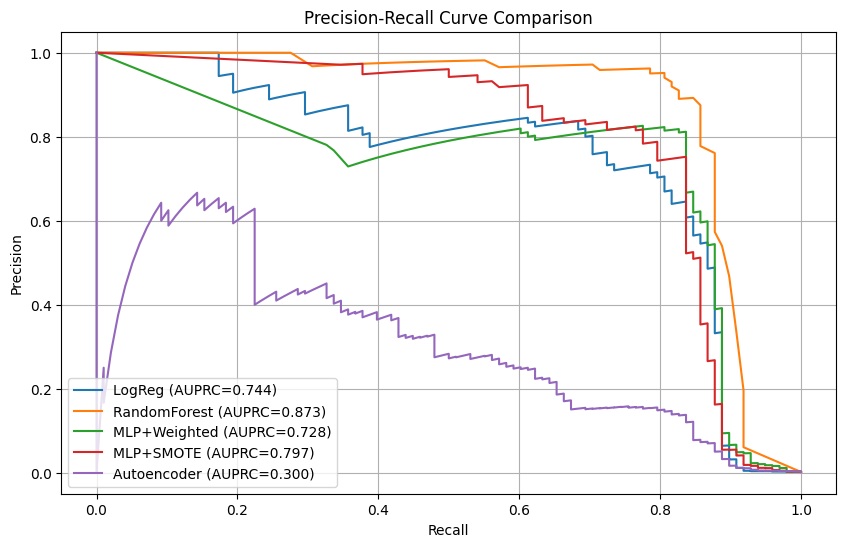

In [25]:
# ==========================================
# Step 5: Visualization Comparison
# ==========================================
print("\nSummary of all model results:")
print(pd.DataFrame(results).T)

plt.figure(figsize=(10, 6))

for name, preds in [("LogReg", y_pred_lr), ("RandomForest", y_pred_rf),
                    ("MLP+Weighted", y_pred_mlp_w), ("MLP+SMOTE", y_pred_mlp_s),
                    ("Autoencoder", y_pred_prob_ae)]:
    p, r, _ = precision_recall_curve(y_test, preds)

    score = results.get(name, {}).get('AUPRC', 0)
    if name == "LogReg": score = results["Logistic Regression"]["AUPRC"]
    if name == "RandomForest": score = results["Random Forest"]["AUPRC"]
    if name == "MLP+Weighted": score = results["MLP + Weighted Loss"]["AUPRC"]
    if name == "MLP+SMOTE": score = results["MLP + SMOTE"]["AUPRC"]

    plt.plot(r, p, label=f'{name} (AUPRC={score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2_mu = nn.Linear(32, 8)      # mean μ
        self.fc2_logvar = nn.Linear(32, 8)  # log(σ^2)

        # Decoder
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        # Reparameterization Trick
        # z = μ + σ * ε (ε ~ N(0, 1))
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.fc4(h3) # output original Logits (for the steadiness of MSELoss)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE: Reconstruction error + KL divergence
def loss_function_vae(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (MSE)
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # 2. KL divergence
    # measures the difference between the learned distribution and the standard normal distribution
    # formula: -0.5 * sum(1 + log(σ^2) - μ^2 - σ^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

def train_vae(train_loader, input_dim, device, epochs=20):
    model = VAE(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(batch_X)

            loss = loss_function_vae(recon_batch, batch_X, mu, logvar)
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

    return model

def evaluate_vae(model, X_test, y_test, device):
    model.eval()
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        recon_x, _, _ = model(X_tensor)
        # Calculate the reconstruction error (MSE) for each sample.
        # dim=1 means calculating the mean of all features for each sample
        mse = torch.mean(torch.pow(X_tensor - recon_x, 2), dim=1).cpu().numpy()

    # Normalized error as "fraud probability"
    y_prob = (mse - mse.min()) / (mse.max() - mse.min())

    evaluate_model("Variational Autoencoder (VAE)", y_test, y_prob)
    return y_prob

vae_model = train_vae(train_loader_ae, X_train.shape[1], device)

vae_scores = evaluate_vae(vae_model, X_test, y_test, device)

Epoch 1, Loss: 27.4164
Epoch 2, Loss: 24.0992
Epoch 3, Loss: 22.2268
Epoch 4, Loss: 21.2499
Epoch 5, Loss: 20.6313
Epoch 6, Loss: 20.1960
Epoch 7, Loss: 19.8296
Epoch 8, Loss: 19.5019
Epoch 9, Loss: 19.2393
Epoch 10, Loss: 19.0236
Epoch 11, Loss: 18.8067
Epoch 12, Loss: 18.6406
Epoch 13, Loss: 18.5296
Epoch 14, Loss: 18.4134
Epoch 15, Loss: 18.3266
Epoch 16, Loss: 18.2724
Epoch 17, Loss: 18.1986
Epoch 18, Loss: 18.1535
Epoch 19, Loss: 18.1279
Epoch 20, Loss: 18.0790

--- Variational Autoencoder (VAE) ---
Best Threshold: 0.07 (Max F1: 0.6349)
AUPRC: 0.6033
Recall: 0.6122
Precision: 0.6593
Confusion Matrix:
[[56833    31]
 [   38    60]]
